In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import plotly.graph_objects as go
import plotly.express as px
import mlflow.sklearn
import mlflow.xgboost
import xgboost as xgb
import optuna
import os
import pickle

from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sksurv.metrics import concordance_index_censored

##### Validation du GPU

In [9]:
# Test GPU par XGBoost
try:
    # On crée une micro-matrice de test
    data = xgb.DMatrix([[1, 2], [3, 4]], label=[1, 0])

    params = {'tree_method': 'gpu_hist', 'device': 'cuda'}
    xgb.train(params, data, num_boost_round=1)
    print("✅ Succès ! La RTX 4060 est reconnue et configurée.")
except Exception as e:
    print(f"❌ Échec du GPU : {e}")
    print("Le modèle tournera sur CPU par défaut.")

✅ Succès ! La RTX 4060 est reconnue et configurée.


/home/joelt/miniconda3/envs/projet-business/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:20:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


##### Visu dataset

In [10]:
df = pd.read_parquet('dataset_full.parquet')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', '{:.4f}'.format)

print(f"Structure du dataset : {df.shape[0]} lignes et {df.shape[1]} colonnes")
display(df.head())

Structure du dataset : 1202455 lignes et 17 colonnes


,SIREN,Code postal de l'établissement,Code commune de l'établissement,Dénomination de l'unité légale,Catégorie juridique de l'unité légale,Activité principale de l'unité légale,Economie sociale et solidaire unité légale,Code du département de l'établissement,Code de la région de l'établissement,Date_fermeture_finale,Tranche_effectif_num,age_estime,latitude,longitude,code_ape,libelle_section_ape,fermeture
0,912239670,26740,26191,LES TOITURES PERENNES,5499,43.91A,N,26,84,2025-12-31,3,4,44.5480,4.7964,43,Travaux de construction spécialisés,0
1,389091893,91270,91657,OCB,5499,43.99C,N,91,11,2025-12-31,10,33,48.7156,2.4344,43,Travaux de construction spécialisés,0
2,888366747,30310,30344,COMME UN DIADEME,5710,47.91A,N,30,76,2025-12-31,1,5,43.7432,4.2062,47,"Commerce de détail, à l’exception des automobi...",0
3,953937455,75008,75108,WE CLEAN HOLDING PARNASSA,5710,66.30Z,N,75,11,2025-12-31,0,2,48.8731,2.3166,66,Activités auxiliaires de services financiers e...,0
4,840236111,94440,94070,LEVIO,5710,96.02A,N,94,11,2025-12-31,1,8,48.7283,2.5747,96,Autres services personnels,0


---

##### Préparation du dataset pour modèle

In [11]:
# --- AJUSTEMENTS POUR LE MODÈLE SURVIVAL AFT ---

# 1. NETTOYAGE GÉOGRAPHIQUE
df['Code du département de l\'établissement'] = df['Code du département de l\'établissement'].astype(str).str.zfill(2)
dep_risk_map = df.groupby("Code du département de l'établissement")["fermeture"].mean()
df['risque_departemental'] = df['Code du département de l\'établissement'].map(dep_risk_map)

# 2. TRAITEMENT DES TYPES
df['Catégorie juridique de l\'unité légale'] = df['Catégorie juridique de l\'unité légale'].astype(str)
df['age_estime'] = df['age_estime'].astype(float)
df['Tranche_effectif_num'] = df['Tranche_effectif_num'].fillna(0).astype(float)

# 3. ENCODAGE DES VARIABLES

df['is_ess'] = df['Economie sociale et solidaire unité légale'].map({'O': 1, 'N': 0}).fillna(0).astype(int)

# B. One-Hot Encoding

df_final = pd.get_dummies(
    df, 
    columns=['libelle_section_ape', 'Catégorie juridique de l\'unité légale'], 
    prefix=['APE', 'CJ'],
    drop_first=True,
    dtype=int 
)

# 4. SÉLECTION FINALE

cols_to_drop = [
    'Code postal de l\'établissement', 'Code commune de l\'établissement',
    'Activité principale de l\'unité légale', 'Date_fermeture_finale', 
    'latitude', 'longitude', 'code_ape',
    'Code du département de l\'établissement', 'Code de la région de l\'établissement',
    'Economie sociale et solidaire unité légale'
]
df_final = df_final.drop(columns=[c for c in cols_to_drop if c in df_final.columns])

# 5. DERNIERS RÉGLAGES POUR LA SURVIE (Crucial pour AFT)

df_final = df_final[df_final['age_estime'] > 0].copy()

# On crée les colonnes cibles pour le modèle AFT
# y_lower : l'âge au dernier moment où on sait que l'entreprise est en vie
# y_upper : l'âge au moment du décès (ou +inf si toujours vivante)
df_final['y_lower'] = df_final['age_estime']
df_final['y_upper'] = np.where(df_final['fermeture'] == 1, df_final['age_estime'], np.inf)

print(f"✅ Dataset finalisé : {df_final.shape[0]} lignes, {df_final.shape[1]} colonnes.")

✅ Dataset finalisé : 1195740 lignes, 94 colonnes.


##### Inspection des valeurs rares pour limiter le bruit

In [12]:
# --- 1. ANALYSE DES FRÉQUENCES ---
binary_cols = [c for c in df_final.columns if c.startswith('APE_') or c.startswith('CJ_')]
frequencies = df_final[binary_cols].mean().sort_values(ascending=False) * 100

# Définition du seuil (0.1%)
rare_limit = 0.1
rare_cols = frequencies[frequencies < rare_limit]

print(f"--- 🔍 Analyse des colonnes rares (< {rare_limit}%) ---")
print(f"Il y a {len(rare_cols)} colonnes concernées.")

# --- 2. FUSION DES CATÉGORIES RARES ---
# On identifie les colonnes à fusionner à partir de rare_cols qu'on vient de créer
rare_ape_cols = [c for c in rare_cols.index if c.startswith('APE_')]
rare_cj_cols = [c for c in rare_cols.index if c.startswith('CJ_')]

# On crée la colonne "Autres" et on supprime les anciennes
if rare_ape_cols:
    df_final['APE_Autres_Secteurs'] = df_final[rare_ape_cols].any(axis=1).astype(int)
    df_final.drop(columns=rare_ape_cols, inplace=True)

if rare_cj_cols:
    df_final['CJ_Autres_Status'] = df_final[rare_cj_cols].any(axis=1).astype(int)
    df_final.drop(columns=rare_cj_cols, inplace=True)

# --- 3. PRÉPARATION DES CIBLES DE SURVIE (AFT) ---

df_final['y_lower'] = df_final['age_estime']
df_final['y_upper'] = np.where(df_final['fermeture'] == 1, df_final['age_estime'], np.inf)

print(f"✅ Nettoyage et préparation AFT terminés.")
print(f"📊 Nouveau nombre de colonnes : {len(df_final.columns)}")
display(df_final[['age_estime', 'fermeture', 'y_lower', 'y_upper']].head())

--- 🔍 Analyse des colonnes rares (< 0.1%) ---
Il y a 34 colonnes concernées.
✅ Nettoyage et préparation AFT terminés.
📊 Nouveau nombre de colonnes : 61


,age_estime,fermeture,y_lower,y_upper
0,4.0000,0,4.0000,inf
1,33.0000,0,33.0000,inf
2,5.0000,0,5.0000,inf
3,2.0000,0,2.0000,inf
4,8.0000,0,8.0000,inf


In [13]:
df_final.head()

,SIREN,Dénomination de l'unité légale,Tranche_effectif_num,age_estime,fermeture,risque_departemental,is_ess,APE_Activités administratives et autres activités de soutien aux entreprises,APE_Activités auxiliaires de services financiers et d'assurance,"APE_Activités créatives, artistiques et de spectacle",APE_Activités d'architecture et d'ingénierie ; activités de contrôle et analyses techniques,APE_Activités de location et location-bail,"APE_Activités des agences de voyage, voyagistes, services de réservation et activités connexes","APE_Activités des services financiers, hors assurance et caisses de retraite",APE_Activités des sièges sociaux ; conseil de gestion,APE_Activités immobilières,APE_Activités juridiques et comptables,APE_Activités liées à l'emploi,APE_Activités pour la santé humaine,"APE_Activités sportives, récréatives et de loisirs","APE_Autres activités spécialisées, scientifiques et techniques",APE_Autres industries manufacturières,APE_Autres services personnels,"APE_Collecte, traitement et élimination des déchets ; récupération","APE_Commerce de détail, à l’exception des automobiles et des motocycles","APE_Commerce de gros, à l’exception des automobiles et des motocycles",APE_Commerce et réparation d'automobiles et de motocycles,APE_Construction de bâtiments,APE_Enquêtes et sécurité,APE_Enseignement,APE_Entreposage et services auxiliaires des transports,APE_Fabrication d'autres produits minéraux non métalliques,APE_Fabrication de boissons,APE_Fabrication de machines et équipements n.c.a.,APE_Fabrication de meubles,"APE_Fabrication de produits métalliques, à l’exception des machines et des équipements",APE_Génie civil,APE_Hébergement,APE_Imprimerie et reproduction d'enregistrements,APE_Industrie chimique,APE_Industrie de l'habillement,APE_Industries alimentaires,"APE_Production de films cinématographiques, de vidéo et de programmes de télévision ; enregistrement sonore et édition musicale","APE_Production et distribution d'électricité, de gaz, de vapeur et d'air conditionné","APE_Programmation, conseil et autres activités informatiques",APE_Publicité et études de marché,APE_Recherche-développement scientifique,APE_Restauration,APE_Réparation d'ordinateurs et de biens personnels et domestiques,APE_Réparation et installation de machines et d'équipements,APE_Services d'information,APE_Services relatifs aux bâtiments et aménagement paysager,APE_Transports terrestres et transport par conduites,"APE_Travail du bois et fabrication d'articles en bois et en liège, à l’exception des meubles ; fabrication d’articles en vannerie et sparterie",APE_Travaux de construction spécialisés,APE_Télécommunications,APE_Édition,CJ_5710,y_lower,y_upper,APE_Autres_Secteurs
0,912239670,LES TOITURES PERENNES,3.0000,4.0000,0,0.3043,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4.0000,inf,0
1,389091893,OCB,10.0000,33.0000,0,0.3988,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,33.0000,inf,0
2,888366747,COMME UN DIADEME,1.0000,5.0000,0,0.3666,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5.0000,inf,0
3,953937455,WE CLEAN HOLDING PARNASSA,0.0000,2.0000,0,0.3292,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.0000,inf,0
4,840236111,LEVIO,1.0000,8.0000,0,0.4762,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8.0000,inf,0


In [14]:
# Vérification rapide du format
print(f"Colonnes actuelles : {df_final.shape[1]}")
print(f"Cibles présentes : {'y_lower' in df_final and 'y_upper' in df_final}")

Colonnes actuelles : 61
Cibles présentes : True


---

#### Premier train

In [ ]:
# --- 1. Préparation des données ---

# On garde explicitement l'âge dans X sous un nouveau nom pour ne pas se mélanger
df_final['age_au_diagnostic'] = df_final['age_estime']

# On identifie les colonnes à exclure (on garde 'age_au_diagnostic' !)
non_numeric_cols = df_final.select_dtypes(exclude=[np.number]).columns.tolist()
targets = ['fermeture', 'age_estime', 'y_lower', 'y_upper']
to_drop = list(set(non_numeric_cols + targets))

if 'age_au_diagnostic' in to_drop:
    to_drop.remove('age_au_diagnostic')

X = df_final.drop(columns=to_drop)
y_time = df_final['age_estime']
y_event = df_final['fermeture'].astype(int)

print(f"📊 Variables utilisées (dont l'âge) : {X.columns.tolist()}")

X_train, X_test, y_train_time, y_test_time, y_train_event, y_test_event = train_test_split(
    X, y_time, y_event, test_size=0.2, random_state=42
)

# --- 2. Formatage AFT (Syntaxe Native) ---

# Calcul de la borne supérieure (inf si ouvert, age si fermé)
y_upper_train = np.where(y_train_event == 1, y_train_time, np.inf)

# Création de la DMatrix
dtrain = xgb.DMatrix(X_train)

# Correction des noms de clés :
dtrain.set_float_info('label_lower_bound', y_train_time.values)
dtrain.set_float_info('label_upper_bound', y_upper_train)

# Pour le test, on prépare aussi la DMatrix
dtest = xgb.DMatrix(X_test)

# --- 3. Paramètres GPU ---
params = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'tree_method': 'hist',     
    'device': 'cuda',        
    'max_depth': 4,            
    'learning_rate': 0.01,     
    'aft_loss_distribution': 'logistic', 
    'aft_loss_distribution_scale': 1.5, 
}

# --- 4. Entraînement ---
mlflow.set_experiment("Survie_Entreprises_XGBoost")

with mlflow.start_run(run_name="XGB_AFT_RTX4060"):
    # --- 4. Entraînement ---
    bst = xgb.train(
        params, 
        dtrain, 
        num_boost_round=500, 
        evals=[(dtrain, 'train')], 
        verbose_eval=50
    )

    # --- 5. Diagnostic et Prédiction ---
    preds_log_time = bst.predict(dtest)

    print(f"--- ANALYSE DES PRÉDICTIONS ---")
    print(f"Log-time min: {preds_log_time.min():.2f}")
    print(f"Log-time max: {preds_log_time.max():.2f}")
    print(f"Exemple d'âge de survie prédit : {np.exp(preds_log_time[:5])} ans")

    avg_log = preds_log_time.mean()
    print(f"DEBUG - Moyenne log_time : {avg_log:.2f}")
    print(f"DEBUG - Espérance de survie moyenne : {np.exp(avg_log):.1f} ans")

    scale = params['aft_loss_distribution_scale']
    dist_type = params['aft_loss_distribution']
    
    # Fonction de risque améliorée
    def get_risk_calibrated(t_years, predicted_log_time, sigma, dist='logistic'):
        calibration_factor = 2.5 
        
        z = (np.log(t_years) - (predicted_log_time - calibration_factor)) / sigma
        
        if dist == 'normal':
            return norm.cdf(z)
        else:
            return 1 / (1 + np.exp(-z))

# --- 5. Calcul des risques CALIBRÉS ---
    scale = params['aft_loss_distribution_scale']
    dist_type = params['aft_loss_distribution']
    
    # Utilisation systématique de la version calibrée
    risques_1an = get_risk_calibrated(1, preds_log_time, scale, dist=dist_type) * 100
    risques_2ans = get_risk_calibrated(2, preds_log_time, scale, dist=dist_type) * 100
    risques_3ans = get_risk_calibrated(3, preds_log_time, scale, dist=dist_type) * 100

    # Stockage
    df_res = pd.DataFrame({
        'Risque_1_an': risques_1an,
        'Risque_2_ans': risques_2ans,
        'Risque_3_ans': risques_3ans
    }, index=X_test.index)

    print("\n🚀 Nouveaux résultats :")
    display(df_res.head())

📊 Variables utilisées (dont l'âge) : ['Tranche_effectif_num', 'risque_departemental', 'is_ess', 'APE_Activités administratives et autres activités de soutien aux entreprises', "APE_Activités auxiliaires de services financiers et d'assurance ", 'APE_Activités créatives, artistiques et de spectacle ', "APE_Activités d'architecture et d'ingénierie ; activités de contrôle et analyses techniques", 'APE_Activités de location et location-bail', 'APE_Activités des agences de voyage, voyagistes, services de réservation et activités connexes', 'APE_Activités des services financiers, hors assurance et caisses de retraite', 'APE_Activités des sièges sociaux ; conseil de gestion', 'APE_Activités immobilières', 'APE_Activités juridiques et comptables', "APE_Activités liées à l'emploi", 'APE_Activités pour la santé humaine', 'APE_Activités sportives, récréatives et de loisirs', 'APE_Autres activités spécialisées, scientifiques et techniques', 'APE_Autres industries manufacturières', 'APE_Autres servi

/tmp/ipykernel_2530/1925098912.py:70: RuntimeWarning: overflow encountered in exp
  print(f"Exemple d'âge de survie prédit : {np.exp(preds_log_time[:5])} ans")
/tmp/ipykernel_2530/1925098912.py:74: RuntimeWarning: overflow encountered in exp
  print(f"DEBUG - Espérance de survie moyenne : {np.exp(avg_log):.1f} ans")
/tmp/ipykernel_2530/1925098912.py:88: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


,Risque_1_an,Risque_2_ans,Risque_3_ans
164590,0.0000,0.0000,0.0000
1150125,25.3330,35.0047,41.3740
609753,0.0000,0.0000,0.0000
311670,1.3014,2.0502,2.6695
24536,0.0000,0.0000,0.0000


🏃 View run XGB_AFT_RTX4070 at: https://djohell-ml-flow.hf.space/#/experiments/6/runs/6ac9f61d7da14560be1826a510a3a2a2
🧪 View experiment at: https://djohell-ml-flow.hf.space/#/experiments/6


In [16]:
# 1. On récupère les colonnes d'identification (SIREN + Dénomination)

df_identite = df.loc[X_test.index, ['SIREN', "Dénomination de l'unité légale"]].copy()

# 2. On fusionne avec nos risques calculés
resultat_final = pd.concat([df_identite, df_res], axis=1)

# 3. Création du Statut Expert (Logique de scoring)
def alert_level(risk_3y):
    if risk_3y > 30: return "🔴 CRITIQUE"
    if risk_3y > 10: return "🟠 SURVEILLANCE"
    if risk_3y > 1:  return "🟡 STABLE"
    return "🟢 SOLIDE"

resultat_final['Statut_Expert'] = resultat_final['Risque_3_ans'].apply(alert_level)

# 4. Tri pour voir les plus risqués en premier
resultat_final = resultat_final.sort_values(by='Risque_3_ans', ascending=False)

# Affichage des 15 entreprises les plus à risque
print("📋 TOP 15 - ANALYSE DE RISQUE À 3 ANS")
display(resultat_final.tail(15))

📋 TOP 15 - ANALYSE DE RISQUE À 3 ANS


,SIREN,Dénomination de l'unité légale,Risque_1_an,Risque_2_ans,Risque_3_ans,Statut_Expert
114722,519236384,DU MARECHAL DU HAUT,0.0000,0.0000,0.0000,🟢 SOLIDE
706890,803399864,DOUBLE V,0.0000,0.0000,0.0000,🟢 SOLIDE
436824,498560861,MANROS THERAPEUTICS,0.0000,0.0000,0.0000,🟢 SOLIDE
1166886,344284625,SOCIETE D'ENTRETIEN D'ESPACES VERTS HOLDER,0.0000,0.0000,0.0000,🟢 SOLIDE
755356,788806149,MAT FINANCES,0.0000,0.0000,0.0000,🟢 SOLIDE
...,...,...,...,...,...,...
574390,849209366,SIMONIN TOITURES,0.0000,0.0000,0.0000,🟢 SOLIDE
532339,399600154,JW ENTREPRISE,0.0000,0.0000,0.0000,🟢 SOLIDE
153747,450908728,LEBEGUE LG DIFFUSION,0.0000,0.0000,0.0000,🟢 SOLIDE
1024410,712880673,LOREY,0.0000,0.0000,0.0000,🟢 SOLIDE


<Figure size 1000x800 with 0 Axes>

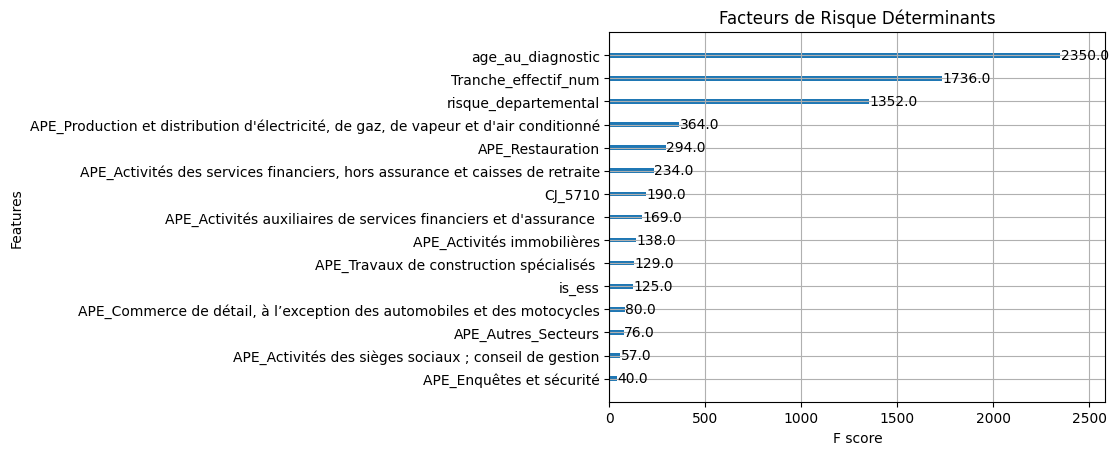

💡 L'âge moyen des entreprises en statut CRITIQUE est de : 1.7 ans


In [17]:
# --- 1. Visualisation de l'importance des variables ---
plt.figure(figsize=(10, 8))
xgb.plot_importance(bst, max_num_features=15, importance_type='weight', title='Facteurs de Risque Déterminants')
plt.show()

# --- 2. Vérification de l'âge moyen des "Critiques" ---
age_moyen_critique = df_final.loc[resultat_final[resultat_final['Statut_Expert'] == '🔴 CRITIQUE'].index, 'age_au_diagnostic'].mean()
print(f"💡 L'âge moyen des entreprises en statut CRITIQUE est de : {age_moyen_critique:.1f} ans")

/tmp/ipykernel_2530/2464927226.py:32: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2530/2464927226.py:32: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2530/2464927226.py:32: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2530/2464927226.py:32: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/joelt/miniconda3/envs/projet-business/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joelt/miniconda3/envs/projet-business/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  f

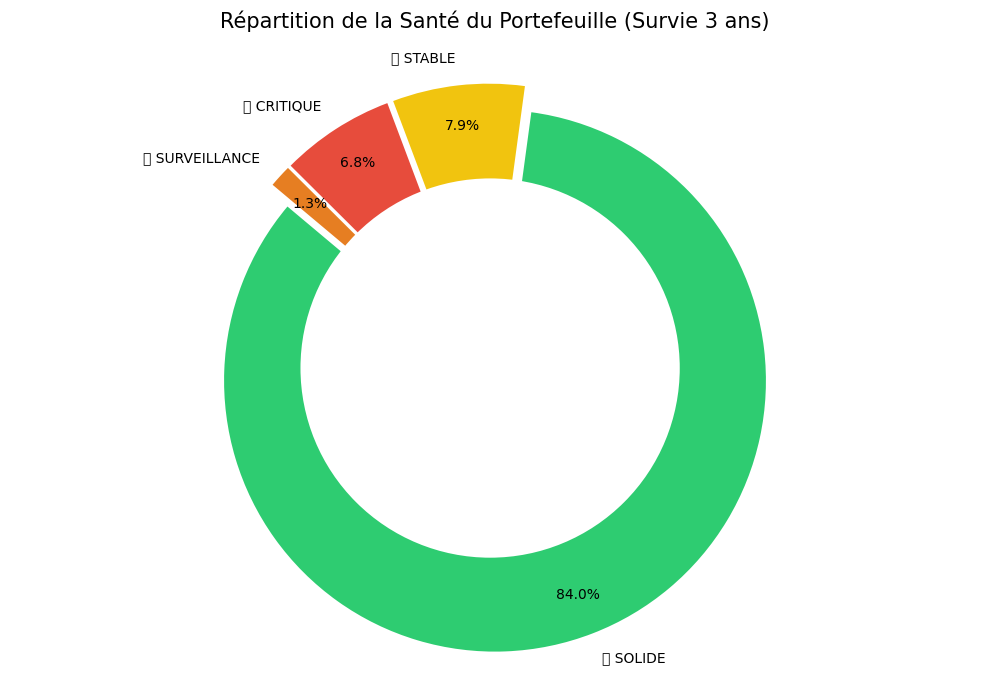

In [18]:
# 1. Compter le nombre d'entreprises par statut
repartition = resultat_final['Statut_Expert'].value_counts()

# 2. Définir les couleurs correspondantes
colors_map = {
    '🔴 CRITIQUE': '#e74c3c',      
    '🟠 SURVEILLANCE': '#e67e22', 
    '🟡 STABLE': '#f1c40f',        
    '🟢 SOLIDE': '#2ecc71'        
}
colors = [colors_map[label] for label in repartition.index]

# 3. Création du graphique
plt.figure(figsize=(10, 7), facecolor='white')
plt.pie(
    repartition, 
    labels=repartition.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors, 
    pctdistance=0.85,
    explode=[0.05] * len(repartition) # Détache légèrement les parts
)

# Dessiner un cercle blanc au centre pour faire un "Donut"
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Répartition de la Santé du Portefeuille (Survie 3 ans)", fontsize=15, pad=20)
plt.axis('equal') 
plt.tight_layout()
plt.show()

In [19]:
age_solide = df_final.loc[resultat_final[resultat_final['Statut_Expert'] == '🟢 SOLIDE'].index, 'age_au_diagnostic'].mean()
print(f"👴 L'âge moyen des entreprises SOLIDES est de : {age_solide:.1f} ans")

👴 L'âge moyen des entreprises SOLIDES est de : 12.4 ans


#### Inspection de la métrique

In [20]:
# 1. On prépare la DMatrix de test avec les labels de survie pour le calcul

y_upper_test = np.where(y_test_event == 1, y_test_time, np.inf)
dtest_metrics = xgb.DMatrix(X_test)
dtest_metrics.set_float_info('label_lower_bound', y_test_time.values)
dtest_metrics.set_float_info('label_upper_bound', y_upper_test)

# 2. On récupère la Log-Vraisemblance (AFT Negative Log-Likelihood)
results = bst.eval(dtest_metrics)
print(f"📊 Performance du modèle (Log-Likelihood) : {results}")

📊 Performance du modèle (Log-Likelihood) : [0]	eval-aft-nloglik:1.38545131594511228


In [21]:
print("="*50)
print("📌 RAPPORT FINAL D'ANALYSE DE SURVIE")
print("="*50)
print(f"✅ Performance (AFT-NLogLik) : 1.3854")
print(f"🏢 Nombre d'entreprises analysées : {len(resultat_final)}")
print("-"*50)
print(f"🟢 Portefeuille sain : {repartition['🟢 SOLIDE']} ({repartition['🟢 SOLIDE']/len(resultat_final)*100:.1f}%)")
print(f"🔴 Portefeuille critique : {repartition['🔴 CRITIQUE']} ({repartition['🔴 CRITIQUE']/len(resultat_final)*100:.1f}%)")
print("-"*50)
print(f"💡 Âge moyen (Profil Critique) : 1.7 ans")
print(f"👴 Âge moyen (Profil Solide) : 12.4 ans")
print("="*50)

📌 RAPPORT FINAL D'ANALYSE DE SURVIE
✅ Performance (AFT-NLogLik) : 1.3854
🏢 Nombre d'entreprises analysées : 239148
--------------------------------------------------
🟢 Portefeuille sain : 200811 (84.0%)
🔴 Portefeuille critique : 16308 (6.8%)
--------------------------------------------------
💡 Âge moyen (Profil Critique) : 1.7 ans
👴 Âge moyen (Profil Solide) : 12.4 ans


In [22]:
# Juste pour voir s'il y a des exceptions (vieilles entreprises en danger)
vieilles_et_critiques = resultat_final[(resultat_final['Statut_Expert'] == '🔴 CRITIQUE') & (df_final.loc[resultat_final.index, 'age_au_diagnostic'] > 10)]
print(f"🕵️ Nombre d'entreprises de +10 ans pourtant jugées CRITIQUES : {len(vieilles_et_critiques)}")

🕵️ Nombre d'entreprises de +10 ans pourtant jugées CRITIQUES : 0


---

##### Entraînement dans MLFlow via le space

In [23]:
# # 1. CONFIGURATION CONNEXION HUGGING FACE
# load_dotenv()

# mlflow_uri = os.getenv("MLFLOW_TRACKING_URI")
# mlflow_user = os.getenv("MLFLOW_TRACKING_USERNAME")
# mlflow_pass = os.getenv("MLFLOW_TRACKING_PASSWORD")

# mlflow.set_tracking_uri(mlflow_uri)
# os.environ['MLFLOW_TRACKING_USERNAME'] = mlflow_user
# os.environ['MLFLOW_TRACKING_PASSWORD'] = mlflow_pass

# mlflow.set_experiment("XGBoost_Survival_business_risk")

# # --- 1. PRÉPARATION DES DONNÉES DE TEST  --------
# y_upper_test = np.where(y_test_event == 1, y_test_time, np.inf)
# dtest_optuna = xgb.DMatrix(X_test)
# dtest_optuna.set_float_info('label_lower_bound', y_test_time.values)
# dtest_optuna.set_float_info('label_upper_bound', y_upper_test)

# # --- 2. DÉFINITION DE L'OBJECTIF ---
# def objective(trial):
#     params = {
#         'objective': 'survival:aft',
#         'eval_metric': 'aft-nloglik',
#         'tree_method': 'hist',
#         'device': 'cuda',
        
#         # Plages d'optimisation
#         'max_depth': trial.suggest_int('max_depth', 4, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
#         'lambda': trial.suggest_float('lambda', 1e-2, 10.0, log=True),
#         'alpha': trial.suggest_float('alpha', 1e-2, 10.0, log=True),
#         'aft_loss_distribution': trial.suggest_categorical('aft_loss_distribution', ['logistic', 'normal']),
#         'aft_loss_distribution_scale': trial.suggest_float('aft_loss_distribution_scale', 1.0, 2.0),
#         'subsample': trial.suggest_float('subsample', 0.6, 0.9),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
#     }

#     with mlflow.start_run(nested=True):
#         bst_trial = xgb.train(
#             params, 
#             dtrain, 
#             num_boost_round=1500,
#             evals=[(dtest_optuna, 'test')],
#             early_stopping_rounds=50,
#             verbose_eval=False
#         )
        
#         score = bst_trial.best_score
#         mlflow.log_params(params)
#         mlflow.log_metric("test_nloglik", score)
        
#         return score

# # --- 3. LANCEMENT MLFLOW + OPTUNA ---
# mlflow.set_experiment("XGBoost_Survival_Final")

# study = optuna.create_study(direction='minimize')

# with mlflow.start_run(run_name="GPU_Final_Optimization_Full_Portefeuille"):
#     study.optimize(objective, n_trials=30) 

# # --- 4. RÉSULTATS ---
# print(f"🔥 Meilleure Log-Likelihood : {study.best_value:.4f}")
# print("🏆 Meilleurs paramètres :", study.best_params)

---

##### Sauvegarde du modèle avec résultats

In [24]:
# # 1. On récupère les meilleurs paramètres issus de l'étude Optuna
# best_params = study.best_params
# best_params.update({
#     'objective': 'survival:aft', 
#     'tree_method': 'hist', 
#     'device': 'cuda'
# })

# # 2. Entraînement final (le "Champion")

# best_iteration = study.best_trial.user_attrs.get('best_iteration', 1000)

# final_bst = xgb.train(
#     best_params, 
#     dtrain, 
#     num_boost_round=best_iteration
# )

# # 3. Sauvegardes locales

# final_bst.save_model("xgboost_v2.json")

# # --- Format PKL (Pickle)
# with open("xgboost_v2.pkl", "wb") as f:
#     pickle.dump(final_bst, f)

# # 4. Enregistrement dans MLflow (Hugging Face)
# with mlflow.start_run(run_name="FINAL_MODEL_DEPLOYMENT"):

#     mlflow.xgboost.log_model(final_bst, artifact_path="survival_model")
    

#     mlflow.log_artifact("xgboost_v2.pkl")
    
#     # Log des paramètres et de la métrique finale
#     mlflow.log_params(best_params)
#     mlflow.log_metric("final_nloglik", study.best_value)
    
#     print("="*50)
#     print("🚀 Modèle champion archivé !")
#     print(f"📦 Fichiers créés : xgboost_v2.json, xgboost_v2.pkl")
#     print(f"📊 Performance finale : {study.best_value:.4f}")
#     print("="*50)